# Cassini Cosmic Dust Analyzer - Project 1: Calibrating CDA
## Part 1: Data Exploration
Welcome to the first Cassini - Cosmic Dust Analyzer (CDA) project. The long-term CDA science project goal is described on my YouTube channel. The entire project is separated in sub-projects, covering miscellaneous intermediate steps and results that'll lead eventually to the final objectives.

This script will start with a data exploration introduction of CDA's calibration data that were provided by R. Srama from the University of Stuttgart, is the Principal Investigator of CDA.

In this script we are going to unzip and read the calibration experiment data; explore it; obtain the columns of interes and conduct some data engineering and filtering. We will also "add some phyiscs" and store it for later calibration scripts!

## Read in the data

In [1]:
# Import default libraries
import pathlib
import zipfile

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Matplotlib darkmode
plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Open and unzip the data
with zipfile.ZipFile("data/level0/evalu9-QIQTQC.srama_stuebig.4706.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("data/level0")

In [3]:
# To be honest ... I already changed the data and we will obtain only the first 29 columns
# A detailed description is given in the corresponding YouTube video
COL_NAMES = ['REF_NR', \
             'SECONDS', \
             'PSU_VEL', \
             'QP_VEL', \
             'PSU_CHARGE', \
             'MP_PEAKS', \
             'HVC', \
             'X', \
             'Y', \
             'ACC', \
             '#1', \
             'QI', \
             'QI_CHARGE', \
             'QI_T2', \
             'QI_T4', \
             'QI_TR', \
             '#2', \
             'QC', \
             'QC_CHARGE', \
             'QC_T2', \
             'QC_T4', \
             'QC_TR', \
             '#3', \
             'QT', \
             'QT_CHARGE', \
             'QT_T5', \
             'QT_T7', \
             'QT_TR', \
             'TAR']

# Read in the data
cal_df = pd.read_csv("data/level0/evalu9-QIQTQC.srama_stuebig.4706.txt", \
                     names=COL_NAMES, \
                     engine='python', \
                     delim_whitespace=True, \
                     usecols = range(29))

In [4]:
# Let's take a look
cal_df

,REF_NR,SECONDS,PSU_VEL,QP_VEL,PSU_CHARGE,MP_PEAKS,HVC,X,Y,ACC,...,QC_T2,QC_T4,QC_TR,#3,QT,QT_CHARGE,QT_T5,QT_T7,QT_TR,TAR
0,1.998027e+06,35956,17.40,9.9,1.260000e-15,3,1022,0,10,2000,...,0,233,233,#,QT,4.528350e-15,99,99,0,CAT
1,1.998027e+06,36592,12.35,9.9,9.900000e-16,0,1022,0,10,2000,...,17,83,66,#,QT,4.805130e-15,99,99,0,CAT
2,1.998027e+06,37131,18.70,9.9,2.030000e-15,3,1022,0,10,2000,...,0,183,183,#,QT,3.506570e-15,99,99,0,CAT
3,1.998027e+06,37279,29.10,9.9,2.058000e-15,6,1022,0,10,2000,...,17,50,33,#,QT,2.311490e-14,400,533,133,CAT
4,1.998027e+06,37717,11.00,9.9,2.030000e-15,0,1022,0,10,2000,...,0,150,150,#,QT,4.812730e-15,99,99,0,CAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,2.001347e+06,24385,9.68,9.9,2.429000e-15,7,1021,0,0,2000,...,17,200,183,#,QT,4.713840e-15,99,99,0,cCAT
4702,2.001347e+06,25467,14.78,9.9,9.900000e-16,9,1021,0,0,2000,...,17,150,133,#,QT,5.484850e-15,99,99,0,cCAT
4703,2.001347e+06,25940,14.89,9.9,9.900000e-16,4,1021,0,0,2000,...,100,217,117,#,QT,4.707560e-15,99,99,0,cCAT
4704,2.001347e+06,27189,12.29,9.9,2.506000e-15,6,1021,0,0,2000,...,17,117,100,#,QT,5.882370e-15,99,99,0,cCAT


In [5]:
# Our long-term goal: creating calibration function and comparing them with a literature reference
# For this, we are considering only a selected list of columns:
cal_df = cal_df[["PSU_VEL", "PSU_CHARGE", "MP_PEAKS", "ACC",
                 "QI_CHARGE", "QI_TR",
                 "QC_CHARGE", "QC_TR",
                 "QT_CHARGE", "QT_TR",
                 "TAR"]].copy()

# Let's also rename the oIID, cCAT naming etc. and also remove the wall impacts
cal_df.loc[:, "TAR"].replace(["oIID", "cIID"], "IID", inplace=True)
cal_df.loc[:, "TAR"].replace(["oCAT", "cCAT"], "CAT", inplace=True)

cal_df = cal_df.loc[cal_df["TAR"].isin(["IID", "CAT"])].copy()
cal_df.reset_index(drop=True, inplace=True)

In [6]:
# We need now to convert the rise times and charges
ten_nanoseconds = 10.0 * (10.0 ** (-9.0))
one_microsecond = 1.0 * (10.0 ** (-6.0))
one_femto_coloumb = 10.0 ** (-15.0)

# Rise times
cal_df.loc[:, 'QI_TR'] = cal_df['QI_TR'].apply(lambda x: (x * ten_nanoseconds) 
                                                         / one_microsecond).copy()
cal_df.loc[:, 'QC_TR'] = cal_df['QC_TR'].apply(lambda x: (x * ten_nanoseconds)
                                                         / one_microsecond).copy()
cal_df.loc[:, 'QT_TR'] = cal_df['QT_TR'].apply(lambda x: (x * ten_nanoseconds)
                                                         / one_microsecond).copy()

# Charges
cal_df.loc[:, 'QI_CHARGE'] = cal_df['QI_CHARGE'].apply(lambda x: x / one_femto_coloumb).copy()
cal_df.loc[:, 'QC_CHARGE'] = cal_df['QC_CHARGE'].apply(lambda x: x / one_femto_coloumb).copy()
cal_df.loc[:, 'QT_CHARGE'] = cal_df['QT_CHARGE'].apply(lambda x: x / one_femto_coloumb).copy()

cal_df.loc[:, 'PSU_CHARGE'] = cal_df['PSU_CHARGE'].apply(lambda x: x / one_femto_coloumb).copy()

In [7]:
cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR
0,17.40,1.260,3,2000,8.857710,2.83,43.1122,2.33,4.52835,0.00,CAT
1,12.35,0.990,0,2000,8.392480,8.16,243.3150,0.66,4.80513,0.00,CAT
2,18.70,2.030,3,2000,3.897020,4.00,47.3741,1.83,3.50657,0.00,CAT
3,29.10,2.058,6,2000,102.422000,4.33,496.7530,0.33,23.11490,1.33,CAT
4,11.00,2.030,0,2000,0.781009,1.33,42.1289,1.50,4.81273,0.00,CAT
...,...,...,...,...,...,...,...,...,...,...,...
4204,9.68,2.429,7,2000,10.227700,2.84,166.8690,1.83,4.71384,0.00,CAT
4205,14.78,0.990,9,2000,25.061000,2.83,219.0310,1.33,5.48485,0.00,CAT
4206,14.89,0.990,4,2000,7.616550,3.33,42.1660,1.17,4.70756,0.00,CAT
4207,12.29,2.506,6,2000,30.925100,5.34,261.7860,1.00,5.88237,0.00,CAT


## Check implausible data

In [8]:
# Do we have "weird" data in there?
print(f"Number of 0 km/s particles: {len(cal_df.loc[cal_df['PSU_VEL']==0])}")
print(f"Number of 0 fC particles: {len(cal_df.loc[cal_df['PSU_CHARGE']==0])}")

Number of 0 km/s particles: 3
Number of 0 fC particles: 0


In [9]:
# Filter it out
cal_df = cal_df.loc[cal_df['PSU_VEL']>0].copy()

In [10]:
# What about extreme outliers?
cal_df.sort_values(by="PSU_CHARGE").tail(25)

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR
116,2.33,2.948400e+02,0,2000,71.46610,63.50,1.392200e+02,19.00,2.659470e+02,30.00,CAT
1477,1.97,3.850000e+02,0,1500,178.64000,48.67,3.400990e+02,21.50,4.895660e+02,40.00,IID
2334,4.25,9.000000e+02,5,2000,43.94820,9.16,1.048810e+03,2.00,6.916880e+01,52.00,CAT
2507,9.08,8.740000e+15,0,2000,17.94310,36.50,2.706250e+01,29.33,7.478030e+01,50.67,IID
3336,2.33,9.900000e+16,0,2000,13.15150,14.83,9.900000e+16,0.00,4.273530e+01,21.66,IID
3309,5.91,9.900000e+16,0,2000,25.06100,35.00,3.552040e+01,21.17,1.616640e+02,50.00,IID
2948,13.67,9.900000e+16,12,2000,10.22770,4.66,1.313470e+02,0.83,3.778950e+00,0.00,CAT
3385,2.15,9.900000e+16,0,2000,10.22770,23.66,9.900000e+16,0.00,4.257300e+01,30.00,IID
4052,27.21,9.900000e+16,0,2000,26.86930,5.17,2.190310e+02,0.50,1.020800e+01,18.67,CAT
2764,3.93,9.900000e+16,0,2000,10.22770,80.50,4.696140e+01,51.67,1.704180e+01,95.33,CAT


In [11]:
# Filter out the extreme charges
cal_df = cal_df.loc[cal_df["PSU_CHARGE"] < 1000].copy()

## Adding mass

We can compute now also the mass of the particles, using some physics equations! The dust particles are accelerated by a electric field, the resulting energy is the Voltag $U$ times the charge of the particle $q$ resulting:

$E_{\text{el}}=q\cdot U$

Additionally, this energy corresponds to the expected kinetic energy of the particle. This energy depends on the mass $m$ and the velocity $v$ in the following way:

$E_{\text{kin}}=\frac{1}{2}\cdot m\cdot v^2$

If we substitute the energy with the equation shown above we can re-write the equation to determine the mass of the dust particle:

$m = \frac{2\cdot q\cdot U}{v^2}$

In [12]:
# First we need to convert the acceleration voltage from kV to V
cal_df.loc[:, "ACC"] = cal_df["ACC"] * 1000.0

# Compute the mass, based on the equation shown above
cal_df.loc[:, "MASS"] = cal_df.apply(lambda x: (2.0*x["PSU_CHARGE"]*one_femto_coloumb*x["ACC"]) 
                                                / ((x["PSU_VEL"]*1000.0)**2),
                                     axis=1)

## Plotting the dust particle properties

Text(0.5, 0, 'Velocity in km/s')

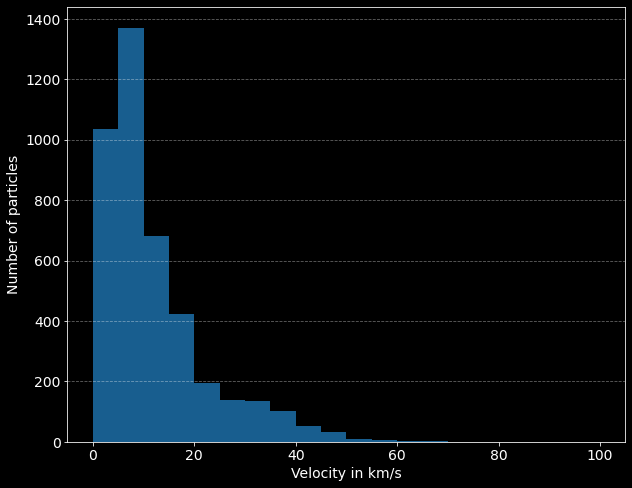

In [13]:
# Let's take a look at the velocity
plt.figure(figsize=(10, 8))

plt.hist(cal_df["PSU_VEL"], bins=np.arange(0,105,5), color="tab:blue", alpha=0.8)

plt.grid(axis="y", ls="dashed", alpha=0.4)

plt.ylabel("Number of particles")
plt.xlabel("Velocity in km/s")

Text(0, 0.5, 'Velocity in km/s')

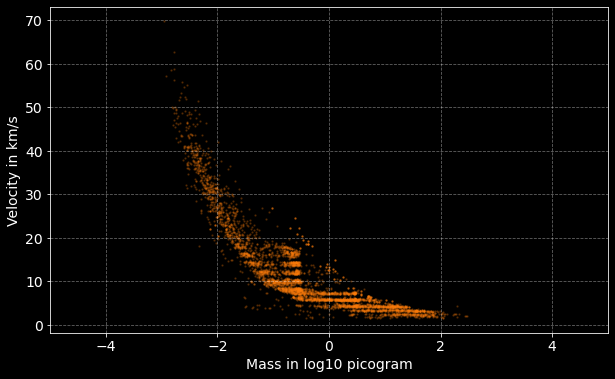

In [14]:
# The dependency between the mass and velocity:
plt.figure(figsize=(10, 6))

plt.scatter(np.log10(cal_df["MASS"]/(10**(-15))),
            cal_df["PSU_VEL"],
            s=2,
            alpha=0.2,
            color="tab:orange")

plt.grid(linestyle="dashed", alpha=0.4)

plt.xlim(-5, 5)

plt.xlabel("Mass in log10 picogram") # Note: we divide kg by 10^-15 -> resuting in pg!
plt.ylabel("Velocity in km/s")

## Some additional statistics

In [15]:
print(f"Number of total events: {len(cal_df)}")
print(f"Number of total IID events: {len(cal_df.loc[cal_df['TAR']=='IID'])}")
print(f"Number of total CAT events: {len(cal_df.loc[cal_df['TAR']=='CAT'])}")

Number of total events: 4184
Number of total IID events: 1650
Number of total CAT events: 2534


In [16]:
# Focus on IID
iid_cal_df = cal_df.loc[cal_df["TAR"]=="IID"]

iid_qi_cal_df = iid_cal_df.loc[(iid_cal_df["QI_TR"] > 0.0) 
                               & (iid_cal_df["QI_CHARGE"] > 0.0)]

iid_qt_cal_df = iid_cal_df.loc[(iid_cal_df["QT_TR"] > 0.0) 
                               & (iid_cal_df["QT_CHARGE"] > 0.0)]

iid_good_cal_df = iid_cal_df.loc[(iid_cal_df["QI_TR"] > 0.0) 
                                 & (iid_cal_df["QI_CHARGE"] > 0.0)
                                 & (iid_cal_df["QT_TR"] > 0.0) 
                                 & (iid_cal_df["QT_CHARGE"] > 0.0)]

print(f"Number of good QT IID impacts: {len(iid_qt_cal_df)}")
print(f"Number of good QI IID impacts: {len(iid_qi_cal_df)}")
print(f"Number of really good IID impacts: {len(iid_good_cal_df)}")

Number of good QT IID impacts: 1539
Number of good QI IID impacts: 1634
Number of really good IID impacts: 1530


In [17]:
# Focus on CAT
cat_cal_df = cal_df.loc[cal_df["TAR"]=="CAT"]

cat_qi_cal_df = cat_cal_df.loc[(cat_cal_df["QI_TR"] > 0.0) 
                               & (cat_cal_df["QI_CHARGE"] > 0.0)
                               & (cat_cal_df["MP_PEAKS"] >= 2.0)]

cat_qc_cal_df = cat_cal_df.loc[(cat_cal_df["QC_TR"] > 0.0) 
                               & (cat_cal_df["QC_CHARGE"] > 0.0)
                               & (cat_cal_df["MP_PEAKS"] >= 2.0)]

cat_good_cal_df = cat_cal_df.loc[(cat_cal_df["QI_TR"] > 0.0) 
                                 & (cat_cal_df["QI_CHARGE"] > 0.0)
                                 & (cat_cal_df["QC_TR"] > 0.0) 
                                 & (cat_cal_df["QC_CHARGE"] > 0.0)
                                 & (cat_cal_df["MP_PEAKS"] >= 2.0)]

print(f"Number of good QC CAT impacts: {len(cat_qc_cal_df)}")
print(f"Number of good QI CAT impacts: {len(cat_qi_cal_df)}")
print(f"Number of really good CAT impacts: {len(cat_good_cal_df)}")

Number of good QC CAT impacts: 1528
Number of good QI CAT impacts: 1506
Number of really good CAT impacts: 1498


## Store the data

In [18]:
# Create level1 data
pathlib.Path("data/level1").mkdir(parents=True, exist_ok=True)
cal_df.to_pickle("data/level1/CDA__CAT_IID_cal_data.pkl")